In [ ]:
"""
NCams Toolbox
Copyright 2020 Charles M Greenspon, Anton Sobinov
https://github.com/CMGreenspon/NCams

Example script for using the various triangulation/reconstruction functions.
    1. Triangulation from multiple CSVs
    2. Smoothing & filtering in 2D/3D
    3. Interactive 3D plotting
    4. Exporting triangulated videos
    5. Triangulation of individual points (not streamlined)
"""

In [1]:
import os
import time
import warnings

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as mpl_pp
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import ncams

%matplotlib widget

In [2]:
# Replace this with your working directory
# BASE_DIR = r'C:\Repositories\NCamsExampleDataExternal\TriangulationPlotting'
BASE_DIR = r'C:\Users\Yiting\YitingData\Hand_tracking'
calibration_date = r'23.08.04_calibration'

# Load calibrations (see intrinsic_extrinsic_calibration.py, section 5)
path_to_ncams_config =  os.path.join(BASE_DIR, calibration_date, 'ncams_config.yaml')
ncams_config = ncams.camera_io.yaml_to_config(path_to_ncams_config)
intrinsics_config, extrinsics_config = ncams.camera_io.load_calibrations(ncams_config)

Camera calibration loaded.
Pose estimation loaded.


In [3]:
#%% 1. Triangulation from multiple CSVs
''' The most common usage for the CSV based triangulation is to direct NCams towards a folder
containing a CSV (in the format of DeepLabCut) for each camera where each CSV has time matched rows 
for each camera (note that the serial number of the camera is used to identify which CSV belongs
to which camera). The following file structure is recommended:
    
- Project/Animal/Session Folder
    - Trial_N
        - Trial_N_cam12345678_DLC.csv
        - Trial_N_cam23456789_DLC.csv
        
By collecting a list of trial directories each can be passed to the "triangulate_csv" function in a 
for loop. The following example shows how to deal with an individual trial.'''

# Declare the folder containing the CSVs for each camera and the desired name
session_date = r'23.08.03_session'
labeled_csv_path = os.path.join(BASE_DIR, session_date, 'Trial_29')

threshold=0.2 # default threshold is 0.9

output_csv_fname = os.path.join(labeled_csv_path, 'triangulated_raw.csv')
ncams.reconstruction.triangulate_csv(ncams_config, labeled_csv_path, intrinsics_config,
                                     extrinsics_config, output_csv_fname=output_csv_fname,
                                     filter_2D=False, filter_3D=False, threshold=threshold)


'C:\\Users\\Yiting\\YitingData\\Hand_tracking\\23.08.03_session\\Trial_29\\triangulated_raw.csv'

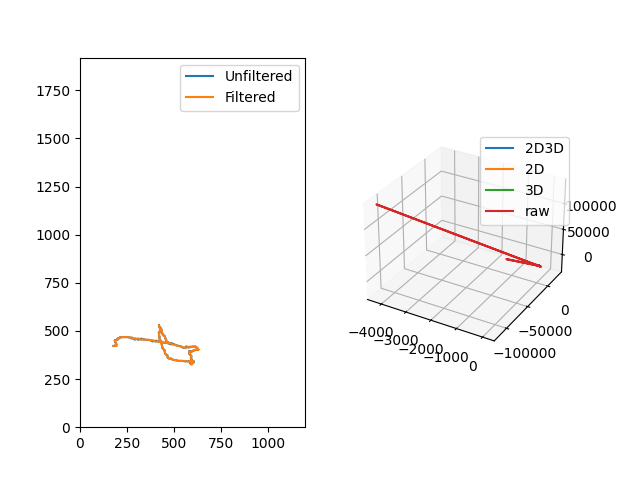

In [4]:
#%% 2. Smoothing and filtering in 2D/3D
''' Due to the inherent noise in the keypoint estimation, both the 2D and 3D data can be erratic.
On the assumption that the noise across cameras is uncorrelated, all cameras can be filtered/smoothed
before triangulation occurs and then the subsequent data can again be filtered/smoothed. Both stages 
are optional. Given that these are options in the "triangulate_csv" function, trying each of these out
is trivial. To save time a quick comparison of the combinations of filtering is given below.'''

# Choose a bodypart number, the camera to view and plot the results in 2D & 3D
ibp = 3
serial_oi = 19472072

# Make a CSV for each possible combination of the triangulated output
output_csv_fname = os.path.join(labeled_csv_path, 'triangulated_2D.csv')
ncams.reconstruction.triangulate_csv(ncams_config, labeled_csv_path, intrinsics_config,
                                     extrinsics_config, output_csv_fname=output_csv_fname,
                                     filter_2D=True, filter_3D=False, threshold=threshold)

output_csv_fname = os.path.join(labeled_csv_path, 'triangulated_3D.csv')
ncams.reconstruction.triangulate_csv(ncams_config, labeled_csv_path, intrinsics_config,
                                     extrinsics_config, output_csv_fname=output_csv_fname,
                                     filter_2D=False, filter_3D=True, threshold=threshold)

output_csv_fname = os.path.join(labeled_csv_path, 'triangulated_2D3D.csv')
ncams.reconstruction.triangulate_csv(ncams_config, labeled_csv_path, intrinsics_config,
                                     extrinsics_config, output_csv_fname=output_csv_fname,
                                     filter_2D=True, filter_3D=True, threshold=threshold)


# Load the 2D CSV, get filtered & unfiltered points
csv_list = ncams.utils.get_file_list('.csv', path=labeled_csv_path)
csv_oi = [s for s in csv_list if str(serial_oi) in s][0]
(formatted_2d_points,_) = ncams.reconstruction.process_points(csv_oi, '2D', filtering=False, threshold=threshold)
unfiltered_2d_points = np.squeeze(formatted_2d_points[:,:,ibp])
(formatted_2d_points,_) = ncams.reconstruction.process_points(csv_oi, '2D', filtering=True, threshold=threshold)
filtered_2d_points = np.squeeze(formatted_2d_points[:,:,ibp])

# Load the 3D CSVs
csv_oi = [s for s in csv_list if 'triangulated' in s]
legend_3d, points_to_plot = [],[]
for fname in csv_oi: # Get the filenames for the legend
    short_path = os.path.split(fname)[1]
    legend_3d.append(short_path[13:-4])
    
    formatted_3d_points = ncams.reconstruction.process_points(fname, '3D', filtering=False, threshold=threshold)
    points_to_plot.append(np.squeeze(formatted_3d_points[:,:,ibp]))


# Plot it all    
fig = mpl_pp.figure()

ax1 = fig.add_subplot(121)
ax1.plot(unfiltered_2d_points[:,0], unfiltered_2d_points[:,1])
ax1.plot(filtered_2d_points[:,0], filtered_2d_points[:,1])
ax1.set_xlim([0, ncams_config['image_size'][0]])
ax1.set_ylim([0, ncams_config['image_size'][1]])
ax1.legend(('Unfiltered', 'Filtered'))

ax2 = fig.add_subplot(122, projection='3d')
for p in range(len(points_to_plot)):
    ax2.plot(points_to_plot[p][:,0], points_to_plot[p][:,1],points_to_plot[p][:,2])
    
ax2.legend(legend_3d)



In [5]:
csv_oi

['C:\\Users\\Yiting\\YitingData\\Hand_tracking\\23.08.03_session\\Trial_29\\triangulated_2D3D.csv',
 'C:\\Users\\Yiting\\YitingData\\Hand_tracking\\23.08.03_session\\Trial_29\\triangulated_2D.csv',
 'C:\\Users\\Yiting\\YitingData\\Hand_tracking\\23.08.03_session\\Trial_29\\triangulated_3D.csv',
 'C:\\Users\\Yiting\\YitingData\\Hand_tracking\\23.08.03_session\\Trial_29\\triangulated_raw.csv']

In [ ]:
# Plot it all    
fig = mpl_pp.figure()

ax1 = fig.add_subplot(121)
ax1.plot(unfiltered_2d_points[:,0], unfiltered_2d_points[:,1])
ax1.plot(filtered_2d_points[:,0], filtered_2d_points[:,1])
ax1.set_xlim([0, ncams_config['image_size'][0]])
ax1.set_ylim([0, ncams_config['image_size'][1]])
ax1.legend(('Unfiltered', 'Filtered'))

ax2 = fig.add_subplot(122, projection='3d')
# raw p=3
ax2.plot(points_to_plot[3][:,0], points_to_plot[3][:,1],points_to_plot[3][:,2])
    


In [ ]:
# # Create interactive plots - try this if matplotlib widget doesn't work
# import plotly.express as px


# # Create a 3D scatter plot using Plotly
# # for p in range(len(points_to_plot)):
# #     ax2.plot(points_to_plot[p][:,0], points_to_plot[p][:,1],points_to_plot[p][:,2])
#     fig = px.line_3d(x=points_to_plot[0][:,0], y=points_to_plot[0][:,1], z=points_to_plot[0][:,2])

# fig.show()

In [ ]:
#%% 3. Interactive 3D plotting
''' In order to make inspecting the outputs of the triangulation easy it is we found it best to 
view it alongside a video. The interactive tool allows scrubbing of individual frames, ideal for
cropping and rotating the projection, as well as inspecting the movement of individual markers.
'''
vid_name = r'cam19472072_video2023-08-03_15-33-29DLC_resnet50_Testing2CamAug5shuffle1_100000_filtered_labeled.mp4'
vid_path = os.path.join(labeled_csv_path, vid_name)
dlc_config_path = os.path.join(BASE_DIR, session_date, 'DLC_config.yaml') # For the skeleton

ncams.reconstruction.interactive_3d_plot(vid_path, output_csv_fname, skeleton_path=dlc_config_path)


In [ ]:
#%% 4. Exporting triangulated videos
''' If one wishes to save the full or cropped version of the video with reconstruction the following
function may be used. There are many options such as adding a third panel for skeletal reconstruction
or an alternate view.
'''

ncams.reconstruction.make_triangulation_video(vid_path, output_csv_fname,
                                              skeleton_config=dlc_config_path, view=(90, 120))
#%% 5. Triangulation of individual points
warnings.warn('Not complete.')
''' This example serves to demonstrate how a given point can be triangulated by itself if desired
for whatever reason. This is not an efficient or particularly useful thing to do but through this
several underlying functions are demonstrated. From the below framework any variation on the supplied
triangulation should be easy.'''

# Create projection matrices for each camera
projection_matrices = []
for icam in range(len(ncams_config['serials'])):
    projection_matrices.append(ncams.camera_tools.make_projection_matrix(
        intrinsics_config['camera_matrices'][icam],
        extrinsics_config['world_orientations'][icam],
        extrinsics_config['world_locations'][icam]))

In [6]:
# Videos and 3D interactive plots

# Setting
vid_name_1 = r'cam19472072_video2023-08-03_15-33-29DLC_resnet50_Testing2CamAug5shuffle1_100000_filtered_labeled.mp4'
vid_path_1 = os.path.join(labeled_csv_path, vid_name_1)
vid_name_2 = r'cam19472089_video2023-08-03_15-33-29DLC_resnet50_Testing2CamAug5shuffle1_100000_filtered_labeled.mp4'
vid_path_2 = os.path.join(labeled_csv_path, vid_name_2)
dlc_config_path = os.path.join(BASE_DIR, session_date, 'DLC_config.yaml') # For the skeleton



In [7]:
import os
import re
import csv
import shutil
import math
import multiprocessing
import functools
import ntpath
import yaml
import cv2
import warnings

from glob import glob
import numpy as np
from tqdm import tqdm
from scipy.signal import medfilt
from scipy.spatial.distance import euclidean
from scipy.stats import norm
from astropy.convolution import convolve, Gaussian1DKernel
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
from itertools import combinations

import matplotlib
import matplotlib.pyplot as mpl_pp
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# from . import utils
# from . import camera_tools


FIG = None
FIGNUM = None
AXS = None
SLIDER = None

In [47]:
triangulated_csv_path = os.path.join(labeled_csv_path, 'triangulated_2D3D.csv')
skeleton_path = dlc_config_path
figure_size=(10, 10)
marker_size=30
skeleton_thickness=1

In [9]:
global FIG, FIGNUM, AXS, SLIDER

# Import the triangulated CSV
with open(triangulated_csv_path, 'r') as f:
    triagreader = csv.reader(f)
    l = next(triagreader)
    bodyparts = []
    for i, bp in enumerate(l):
        if (i-1)%3 == 0:
            bodyparts.append(bp)
    num_bodyparts = len(bodyparts)
    next(triagreader)
    triangulated_points = []
    for row in triagreader:
        triangulated_points.append([[] for _ in range(3)])
        for ibp in range(num_bodyparts):
            triangulated_points[-1][0].append(float(row[1+ibp*3]))
            triangulated_points[-1][1].append(float(row[2+ibp*3]))
            triangulated_points[-1][2].append(float(row[3+ibp*3]))
triangulated_points = np.array(triangulated_points)

In [10]:
video1 = cv2.VideoCapture(vid_path_1)
video2 = cv2.VideoCapture(vid_path_2)

In [11]:
# Check videos
vid_paths = [vid_path_1, vid_path_2]
for i, path in enumerate(vid_paths):
    print(path)
    if not os.path.exists(path):
        raise ValueError('Provided video file does not exist.')
    video = cv2.VideoCapture(path)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    if skeleton_path is not None:
        with open(skeleton_path, 'r') as yaml_file:
            dic = yaml.safe_load(yaml_file)
            bp_list = dic['bodyparts']
            bp_connections = dic['skeleton']
        skeleton = True
    else:
        skeleton = False

    # Check the number of frames vs number of rows in csv
    if num_frames != np.shape(triangulated_points)[0]:
        warnings.warn('Number of frames in video ({}) and rows in CSV ({}) are not equal.'
                      ' Check that the paths given are correct.'.format(
            num_frames, np.shape(triangulated_points)[0]))

C:\Users\Yiting\YitingData\Hand_tracking\23.08.03_session\Trial_29\cam19472072_video2023-08-03_15-33-29DLC_resnet50_Testing2CamAug5shuffle1_100000_filtered_labeled.mp4
C:\Users\Yiting\YitingData\Hand_tracking\23.08.03_session\Trial_29\cam19472089_video2023-08-03_15-33-29DLC_resnet50_Testing2CamAug5shuffle1_100000_filtered_labeled.mp4


In [12]:
ibp = 3 # body part number


In [42]:
# crop
crop_x = [500,1900]
crop_y = [0, 1200]

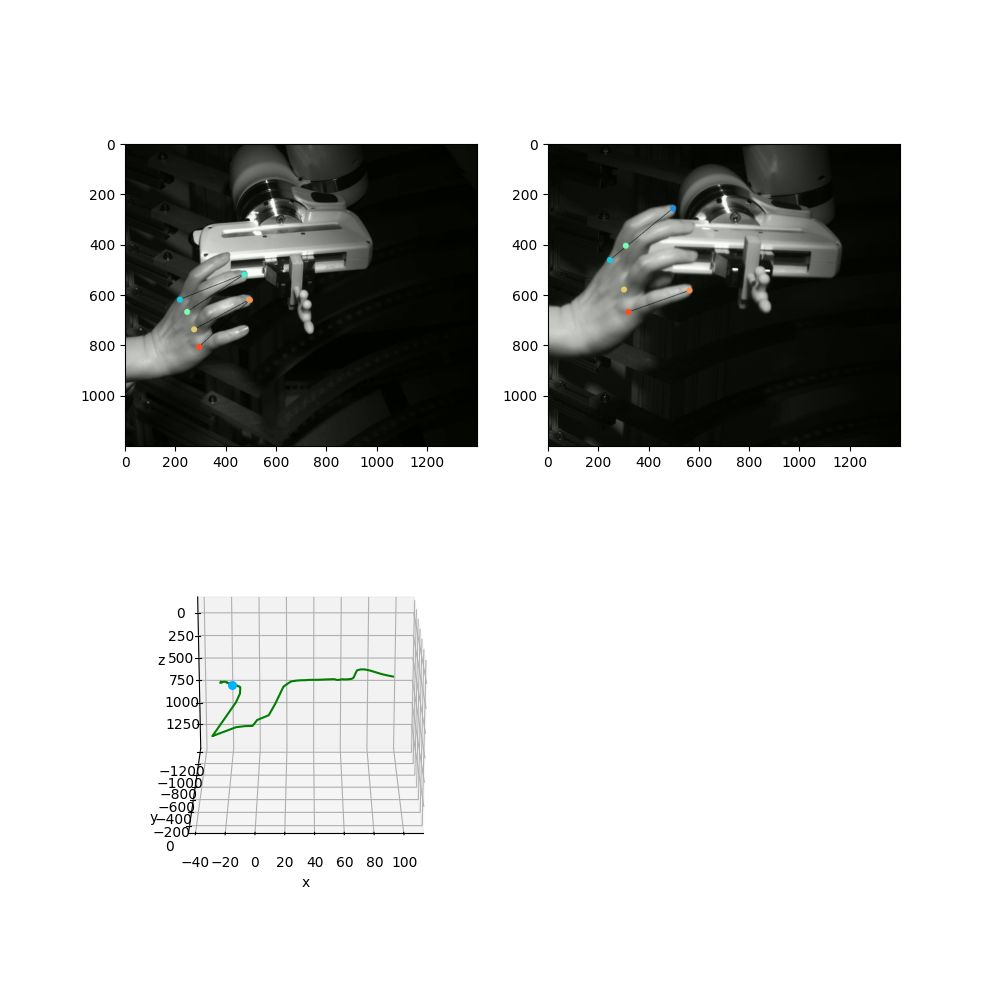

In [51]:
iframe = 150

# Initalize the plots
frame_range = [100, 200]

cmap = matplotlib.cm.get_cmap('jet')
color_idx = np.linspace(0, 1, num_bodyparts)
bp_cmap = cmap(color_idx)
# Limits in space of the markers + 10%
margin = 1.3
pcntl = 2

x_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 0, ibp], pcntl) * margin,
           np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 0, ibp], 100-pcntl) * margin)
y_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 1, ibp], pcntl) * margin,
           np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 1, ibp], 100-pcntl) * margin)
z_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 2, ibp], pcntl) * margin,
           np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 2, ibp], 100-pcntl) * margin)

FIG = mpl_pp.figure(figsize=figure_size)
FIGNUM = mpl_pp.gcf().number
AXS = []
AXS.append(FIG.add_subplot(2, 2, 1))
AXS.append(FIG.add_subplot(2, 2, 2))
AXS.append(FIG.add_subplot(2, 2, 3, projection='3d'))
AXS[2].view_init(elev=90, azim=90)

iframe = int(iframe)
mpl_pp.figure(FIGNUM)
video1.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
fe_vid1, frame_vid1 = video1.read() # Read the frame
video2.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
fe_vid2, frame_vid2 = video2.read() # Read the frame

if fe_vid1 & fe_vid2:
    frame_rgb_vid1 = frame_vid1[..., ::-1].copy()
    frame_rgb_vid2 = frame_vid2[..., ::-1].copy()
    
    AXS[0].cla()
    AXS[0].imshow(frame_rgb_vid1[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:])
    
    AXS[1].cla()
    AXS[1].imshow(frame_rgb_vid2[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:])
    
    AXS[2].cla()
    AXS[2].set_xlim(x_range)
    AXS[2].set_ylim(y_range)
    AXS[2].set_zlim(z_range)
    AXS[2].set_xlabel('x')
    AXS[2].set_ylabel('y')
    AXS[2].set_zlabel('z')
    

    # The entire trajectory
    AXS[2].plot(triangulated_points[frame_range[0]:frame_range[1], 0, ibp],
                triangulated_points[frame_range[0]:frame_range[1], 1, ibp],
                triangulated_points[frame_range[0]:frame_range[1], 2, ibp],
                color='g')
        
    
    # Position at the current frame
    AXS[2].scatter(triangulated_points[iframe, 0, ibp],
                   triangulated_points[iframe, 1, ibp],
                   triangulated_points[iframe, 2, ibp],
                   color=bp_cmap[ibp, :], s=marker_size)   
    AXS[2].view_init(-160,-90)
    
#     # Underlying skeleton
#     if skeleton:
#         for bpc in bp_connections:
#             ibp1 = bp_list.index(bpc[0])
#             ibp2 = bp_list.index(bpc[1])

#             t_point1 = triangulated_points[iframe, :, ibp1]
#             t_point2 = triangulated_points[iframe, :, ibp2]

#             if any(np.isnan(t_point1)) or any(np.isnan(t_point1)):
#                 continue
#             AXS[2].plot([t_point1[0], t_point2[0]],
#                         [t_point1[1], t_point2[1]],
#                         [t_point1[2], t_point2[2]],
#                         color='k', linewidth=skeleton_thickness)

    # # Bodypart markers
    # for ibp in range(np.size(triangulated_points, 2)):
    #     # Markers
    #     AXS[2].scatter(triangulated_points[iframe, 0, ibp],
    #                    triangulated_points[iframe, 1, ibp],
    #                    triangulated_points[iframe, 2, ibp],
    #                    color=bp_cmap[ibp, :], s=marker_size)

In [52]:
# Initalize the plots
frame_range = [100, 200]
for iframe in range(frame_range[0], frame_range[1]):
    cmap = matplotlib.cm.get_cmap('jet')
    color_idx = np.linspace(0, 1, num_bodyparts)
    bp_cmap = cmap(color_idx)
    # Limits in space of the markers + 10%
    margin = 1.3
    pcntl = 2

    x_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 0, ibp], pcntl) * margin,
               np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 0, ibp], 100-pcntl) * margin)
    y_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 1, ibp], pcntl) * margin,
               np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 1, ibp], 100-pcntl) * margin)
    z_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 2, ibp], pcntl) * margin,
               np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 2, ibp], 100-pcntl) * margin)

    FIG = mpl_pp.figure(figsize=figure_size)
    FIGNUM = mpl_pp.gcf().number
    AXS = []
    AXS.append(FIG.add_subplot(2, 2, 1))
    AXS.append(FIG.add_subplot(2, 2, 2))
    AXS.append(FIG.add_subplot(2, 2, 3, projection='3d'))
    AXS[2].view_init(elev=90, azim=90)

    iframe = int(iframe)
    mpl_pp.figure(FIGNUM)
    video1.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
    fe_vid1, frame_vid1 = video1.read() # Read the frame
    video2.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
    fe_vid2, frame_vid2 = video2.read() # Read the frame

    if fe_vid1 & fe_vid2:
        frame_rgb_vid1 = frame_vid1[..., ::-1].copy()
        frame_rgb_vid2 = frame_vid2[..., ::-1].copy()

        AXS[0].cla()
        AXS[0].imshow(frame_rgb_vid1[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:])

        AXS[1].cla()
        AXS[1].imshow(frame_rgb_vid2[crop_y[0]:crop_y[1],crop_x[0]:crop_x[1],:])

        AXS[2].cla()
        AXS[2].set_xlim(x_range)
        AXS[2].set_ylim(y_range)
        AXS[2].set_zlim(z_range)
        AXS[2].set_xlabel('x')
        AXS[2].set_ylabel('y')
        AXS[2].set_zlabel('z')


        # The entire trajectory
        AXS[2].plot(triangulated_points[frame_range[0]:frame_range[1], 0, ibp],
                    triangulated_points[frame_range[0]:frame_range[1], 1, ibp],
                    triangulated_points[frame_range[0]:frame_range[1], 2, ibp],
                   color='g')


        # Position at the current frame
        AXS[2].scatter(triangulated_points[iframe, 0, ibp],
                       triangulated_points[iframe, 1, ibp],
                       triangulated_points[iframe, 2, ibp],
                       color=bp_cmap[ibp, :], s=marker_size)   
        AXS[2].view_init(-160,-90)
        
        tracking_name = '3D_tracking_frame_' + str(iframe) + '.jpg'
        tracking_path = os.path.join(labeled_csv_path, '3D_tracking_fingerbase2_v2_frame100200', tracking_name)

        mpl_pp.savefig(tracking_path)
        mpl_pp.close()

In [ ]:
# Initalize the plots
frame_range = [200, 800]

cmap = matplotlib.cm.get_cmap('jet')
color_idx = np.linspace(0, 1, num_bodyparts)
bp_cmap = cmap(color_idx)
# Limits in space of the markers + 10%
margin = 1.3
pcntl = 2

x_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 0, ibp], pcntl) * margin,
           np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 0, ibp], 100-pcntl) * margin)
y_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 1, ibp], pcntl) * margin,
           np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 1, ibp], 100-pcntl) * margin)
z_range = (np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 2, ibp], pcntl) * margin,
           np.nanpercentile(triangulated_points[frame_range[0]:frame_range[1], 2, ibp], 100-pcntl) * margin)

FIG = mpl_pp.figure(figsize=figure_size)
FIGNUM = mpl_pp.gcf().number
AXS = []
AXS.append(FIG.add_subplot(2, 2, 1))
AXS.append(FIG.add_subplot(2, 2, 2))
AXS.append(FIG.add_subplot(2, 2, 3, projection='3d'))
AXS[2].view_init(elev=90, azim=90)

def update(iframe):
    iframe = int(iframe)
    mpl_pp.figure(FIGNUM)
    video1.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
    fe_vid1, frame_vid1 = video1.read() # Read the frame
    video2.set(cv2.CAP_PROP_POS_FRAMES, iframe) # Set the frame to get
    fe_vid2, frame_vid2 = video2.read() # Read the frame

    if fe_vid1 & fe_vid2:
        frame_rgb_vid1 = frame_vid1[..., ::-1].copy()
        frame_rgb_vid2 = frame_vid2[..., ::-1].copy()

        AXS[0].cla()
        AXS[0].imshow(frame_rgb_vid1)

        AXS[1].cla()
        AXS[1].imshow(frame_rgb_vid2)

        AXS[2].cla()
        AXS[2].set_xlim(x_range)
        AXS[2].set_ylim(y_range)
        AXS[2].set_zlim(z_range)
        AXS[2].set_xlabel('x')
        AXS[2].set_ylabel('y')
        AXS[2].set_zlabel('z')

        # The entire trajectory
        AXS[2].plot(triangulated_points[frame_range[0]:frame_range[1], 0, ibp],
                    triangulated_points[frame_range[0]:frame_range[1], 1, ibp],
                    triangulated_points[frame_range[0]:frame_range[1], 2, ibp])

        # Position at the current frame
        AXS[2].scatter(triangulated_points[iframe, 0, ibp],
                       triangulated_points[iframe, 1, ibp],
                       triangulated_points[iframe, 2, ibp],
                       color=bp_cmap[ibp, :], s=marker_size)   
        AXS[2].view_init(-160,-90)

def arrow_key_image_control(event):
    if event.key == 'left' and SLIDER.val > 0:
        SLIDER.set_val(SLIDER.val - 1)
    elif event.key == 'right' and SLIDER.val < num_frames-1:
        SLIDER.set_val(SLIDER.val + 1)
    else:
        pass

update(0)

axcolor = 'lightgoldenrodyellow'
ax_ind = mpl_pp.axes([0.15, 0.1, 0.65, 0.03], facecolor=axcolor)
SLIDER = mpl_pp.Slider(ax_ind, 'Frame', 0, num_frames-1, valinit=0, valstep=1, valfmt='%u')
SLIDER.on_changed(update)

cid = FIG.canvas.mpl_connect('key_press_event', arrow_key_image_control)

mpl_pp.show()

In [ ]:
# Find outliers

In [ ]:
print(AXS[2].azim)

In [ ]:
print(AXS[2].elev)

In [ ]:
y_range

In [ ]:
x_range = max(triangulated_points[:, 0, ibp]) - min(triangulated_points[:, 0, ibp])
y_range = max(triangulated_points[:, 1, ibp]) - min(triangulated_points[:, 1, ibp])
z_range = max(triangulated_points[:, 2, ibp]) - min(triangulated_points[:, 2, ibp])


In [ ]:
x_range

In [ ]:
y_range

In [ ]:
z_range

In [ ]:
frame_range = [200, 800]
x = triangulated_points[frame_range[0]:frame_range[1], 0, ibp]
y = triangulated_points[frame_range[0]:frame_range[1], 1, ibp]
z = triangulated_points[frame_range[0]:frame_range[1], 2, ibp]

In [ ]:
fig = mpl_pp.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

mpl_pp.show()

In [ ]:
loc_limit = [-250, 250] # mm
triangulated_points[:, 0, ibp]
for i in range(triangulated_points.shape[1]):
    pos = np.squeeze(triangulated_points[:, i, ibp])
    out = np.logical_or(pos<loc_limit[0], pos>loc_limit[1])
    out_idx = [j for j, k in enumerate(out) if k]
    print(out_idx)